In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive.flush_and_unmount()

In [10]:
cd "/content/drive/My Drive/Zindi project2"

/content/drive/My Drive/Zindi project2 (1)


In [12]:
ls

_annotations.csv  classes.csv  sample_submission.csv  test/  train/


In [13]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm

In [3]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6014, done.
remote: Total 6014 (delta 0), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6014/6014), 13.44 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (4061/4061), done.


In [4]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=171488 sha256=e4c90375f83309bed8cc998f9272f5109c78a544cf4aec571041cec5a5508654
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [5]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [14]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [15]:
root = "/content/drive/My Drive/Zindi project2/"
train_img = root+"train"
test_img = root+"test"
train_csv = '/content/drive/My Drive/Zindi project2/_annotations.csv'
sample_submission = root + "sample_submission.csv"
classess = '/content/drive/My Drive/Zindi project2/classes.csv' 

In [16]:
# classes = pd.read_csv(classess)
train = pd.read_csv(train_csv)
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,301,100,330,135
1,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,340,121,370,158
2,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,199,111,223,137
3,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,277,109,295,132
4,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,154,116,174,141


In [17]:
with open("classes.csv","w") as file:
    file.write("helmet,0")

In [18]:
import csv

with open('/content/drive/My Drive/Zindi project2/_annotations.csv') as csv_file:
    btrain = csv.reader(csv_file)

In [19]:
EPOCHS = 1
BATCH_SIZE=8
STEPS = 100 #len(train_df)//BATCH_SIZE #Keeping it small for faster commit
LR=0.02

In [37]:
!"/content/keras-retinanet/keras_retinanet/bin/train.py" --random-transform --weights {PRETRAINED_MODEL} --lr=0.0001 --batch-size=6 --steps=10 --epochs=5 --no-resize csv _annotations.csv classes.csv

2020-09-15 22:55:29.272884: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/content/keras-retinanet/keras_retinanet/bin/train.py", line 556, in <module>
    main()
  File "/content/keras-retinanet/keras_retinanet/bin/train.py", line 486, in main
    train_generator, validation_generator = create_generators(args, backbone.preprocess_image)
  File "/content/keras-retinanet/keras_retinanet/bin/train.py", line 305, in create_generators
    **common_args
  File "/content/keras-retinanet/keras_retinanet/bin/../../keras_retinanet/preprocessing/csv_generator.py", line 158, in __init__
    raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(csv_data_file, e)), None)
  File "<string>", line 3, in raise_from
ValueError: invalid CSV annotations file: _annotations.csv: line 1: malformed x1: invalid literal for int() with base 10: 'width'


In [38]:
train["widthBB"] = train["xmax"] - train["xmin"]
train["heightBB"] = train["ymax"] - train["ymin"]

In [39]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,widthBB,heightBB
0,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,301,100,330,135,29,35
1,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,340,121,370,158,30,37
2,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,199,111,223,137,24,26
3,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,277,109,295,132,18,23
4,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,154,116,174,141,20,25


In [17]:
print(f"Total Bboxes: {train.shape[0]}")

Total Bboxes: 20231


In [18]:
train['width'].unique() == train['height'].unique() == [1024]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [ ]:
#def get_bbox_area(widthBB,heightBB):
 #   widthBB = literal_eval(widthBB)
  #  heightBB = literal_eval(widthBB)
   # return widthBB * heightBB

In [ ]:
train['heightBB'] = train['heightBB'].astype(float)
train['widthBB'] = train['widthBB'].astype(float)

In [41]:
#train['bbox_area'] = train['widthBB','heightBB'].apply(get_bbox_area)
train["bbox_area"] = train["widthBB"] * train["heightBB"]
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,widthBB,heightBB,bbox_area
0,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,301,100,330,135,29,35,1015
1,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,340,121,370,158,30,37,1110
2,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,199,111,223,137,24,26,624
3,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,277,109,295,132,18,23,414
4,004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...,500,375,head,154,116,174,141,20,25,500


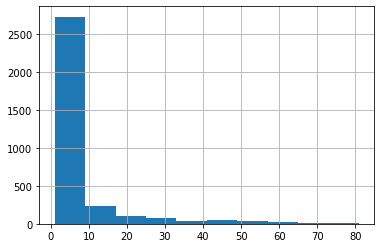

In [42]:
train['bbox_area'].value_counts().hist(bins=10)

In [ ]:
unique_images = train['filename'].unique()
len(unique_images)

5269

In [ ]:
num_total = len(os.listdir(train_img))
num_annotated = len(unique_images)

print(f"There are {num_annotated} annotated images and {num_total - num_annotated} images without annotations.")

There are 5269 annotated images and 5 images without annotations.


In [ ]:
#sources = train['source'].unique()
#print(f"There are {len(sources)} sources of data: {sources}")

In [ ]:
#train['source'].value_counts()

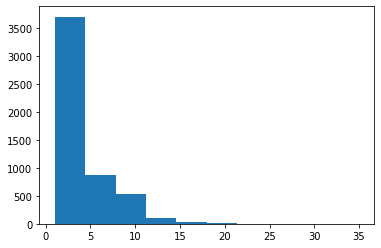

In [ ]:
plt.hist(train['filename'].value_counts(), bins=10)
plt.show()

In [ ]:
#def show_images(images, num = 5):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_img, image_id)
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in train[train['filename'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([train['xmin'], train['ymin'], train['xmin'] + train['widthbb'], train['ymin'] + train['heightbb']], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()

In [ ]:
#show_images(unique_images)

In [43]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20231 entries, 0 to 20230
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   20231 non-null  object
 1   width      20231 non-null  int64 
 2   height     20231 non-null  int64 
 3   class      20231 non-null  object
 4   xmin       20231 non-null  int64 
 5   ymin       20231 non-null  int64 
 6   xmax       20231 non-null  int64 
 7   ymax       20231 non-null  int64 
 8   widthBB    20231 non-null  int64 
 9   heightBB   20231 non-null  int64 
 10  bbox_area  20231 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB
None


In [ ]:
train['class'] = train['class'].astype(str)

In [ ]:
bboxs=[ f"{int(float(train['xmin']))}, {int(float(train['ymin']))}, {int(float(train['xmin']))+int(float(train['widthBB']))}, {int(float(train['ymin'])) + int(float(train['heightBB']))}, train['class']" 
       for x in train]
train['bbox_']=bboxs
train.head()

In [ ]:
train_df=train[['filename','bbox_']]
train_df.head()

In [ ]:
train_df=train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

In [ ]:
with open("annotations.csv","w") as file:
    for idx in range(len(train_df)):
        file.write(train_img+"/"+train_df.iloc[idx,0]+".jpg"+","+train_df.iloc[idx,1]+"\n")

In [ ]:
with open("classes.csv","w") as file:
    file.write("head,0", "helmet,1", "person,2")

In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5'
import requests
requests.get(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


**The next code will train the model, may take some time**

---



**Loading the trained model**

---



In [ ]:
!ls snapshots

In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

**Predictions**

---



In [ ]:
li=os.listdir(test_img)
li[:5]

In [ ]:
def predict(image):
    image = preprocess_image(image.copy())
    #image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

    #boxes /= scale

    return boxes, scores, labels

In [ ]:
THRES_SCORE = 0.5

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{:.3f}".format(score)
        draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_name):
    img_path = test_img+'/'+image_name
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)
    print(boxes[0,0].shape)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_detections(draw, boxes, scores, labels)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
for img in li:
    show_detected_objects(img)

In [ ]:
preds=[]
imgid=[]
for img in tqdm(li,total=len(li)):
    img_path = test_img+'/'+img
    image = read_image_bgr(img_path)
    boxes, scores, labels = predict(image)
    boxes=boxes[0]
    scores=scores[0]
    for idx in range(boxes.shape[0]):
        if scores[idx]>THRES_SCORE:
            box,score=boxes[idx],scores[idx]
            imgid.append(img.split(".")[0])
            preds.append("{} {} {} {} {}".format(score, int(box[0]), int(box[1]), int(box[2]-box[0]), int(box[3]-box[1])))

In [ ]:
preds[0]

In [ ]:
sub={"image_id":imgid, "PredictionString":preds}
sub=pd.DataFrame(sub)
sub.head()

In [ ]:
sub_=sub.groupby(["image_id"])['PredictionString'].apply(lambda x: ' '.join(x)).reset_index()
sub_

In [ ]:
samsub=pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")
samsub.head()

In [ ]:
for idx,imgid in enumerate(samsub['image_id']):
    samsub.iloc[idx,1]=sub_[sub_['image_id']==imgid].values[0,1]
    
samsub.head()

In [ ]:
samsub.to_csv('/kaggle/working/submission.csv',index=False)